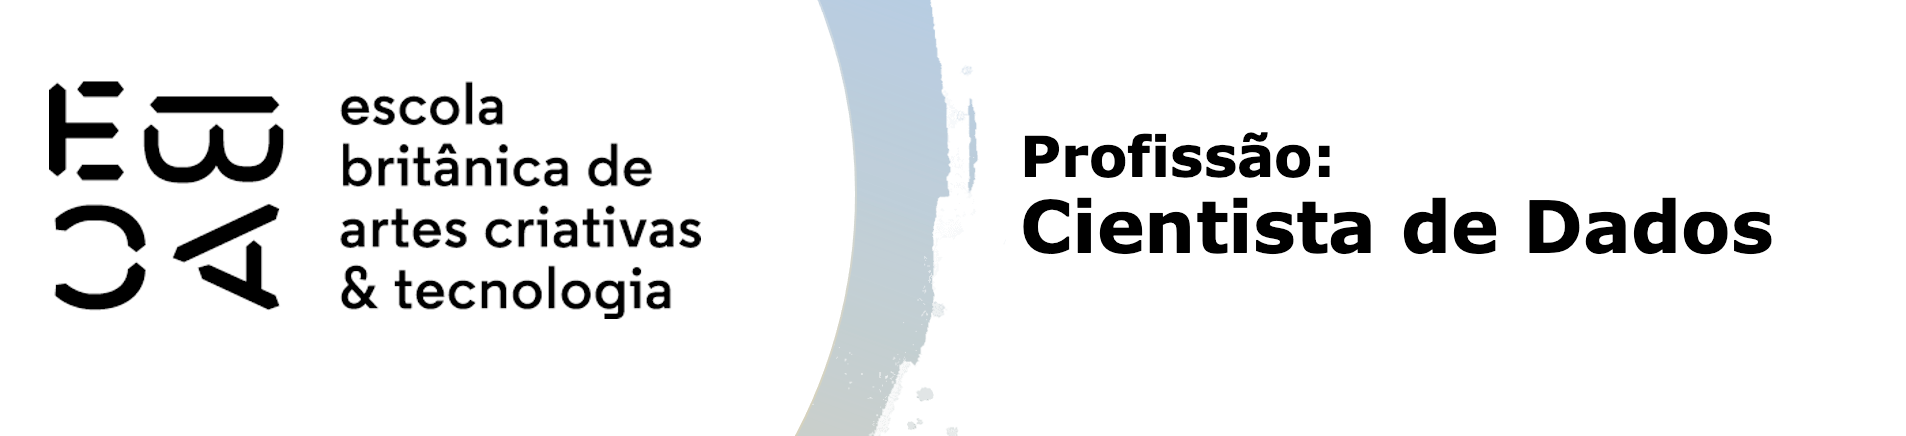

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform

from gower import gower_matrix


In [3]:
df = pd.read_csv('online_shoppers_intention.csv')

In [4]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [6]:
# num momento futuro precisarei de selecionar as variáveis a serem analisadas. daí já deixei aqui
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [7]:
# criar uma df com as variáveis de interesse
df1 = df[['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration','SpecialDay', 'Weekend', 'Month']]
# eu não sabia ao certo se a var Revenue entraria nessa análise
df1.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay,Weekend,Month
0,0,0.0,0,0.0,1,0.000000,0.0,False,Feb
1,0,0.0,0,0.0,2,64.000000,0.0,False,Feb
2,0,0.0,0,0.0,1,0.000000,0.0,False,Feb
3,0,0.0,0,0.0,2,2.666667,0.0,False,Feb
4,0,0.0,0,0.0,10,627.500000,0.0,True,Feb


In [8]:
df1.isnull().sum()
# não há missings

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
SpecialDay                 0
Weekend                    0
Month                      0
dtype: int64

> Não há missing values na base de dados

In [9]:
# distribuição dos dados
df1.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.061427
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.198917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,1.000000


In [10]:
df1.Weekend.value_counts()

Weekend
False    9462
True     2868
Name: count, dtype: int64

In [11]:
df1.Month.value_counts()

Month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64

In [12]:
# visualizar a distribuição dos dados para cada variável
df_melt = df1.melt(id_vars=['Weekend'])
#df_melt = df1.melt()
df_melt

,Weekend,variable,value
0,False,Administrative,0
1,False,Administrative,0
2,False,Administrative,0
3,False,Administrative,0
4,True,Administrative,0
...,...,...,...
98635,True,Month,Dec
98636,True,Month,Nov
98637,True,Month,Nov
98638,False,Month,Nov


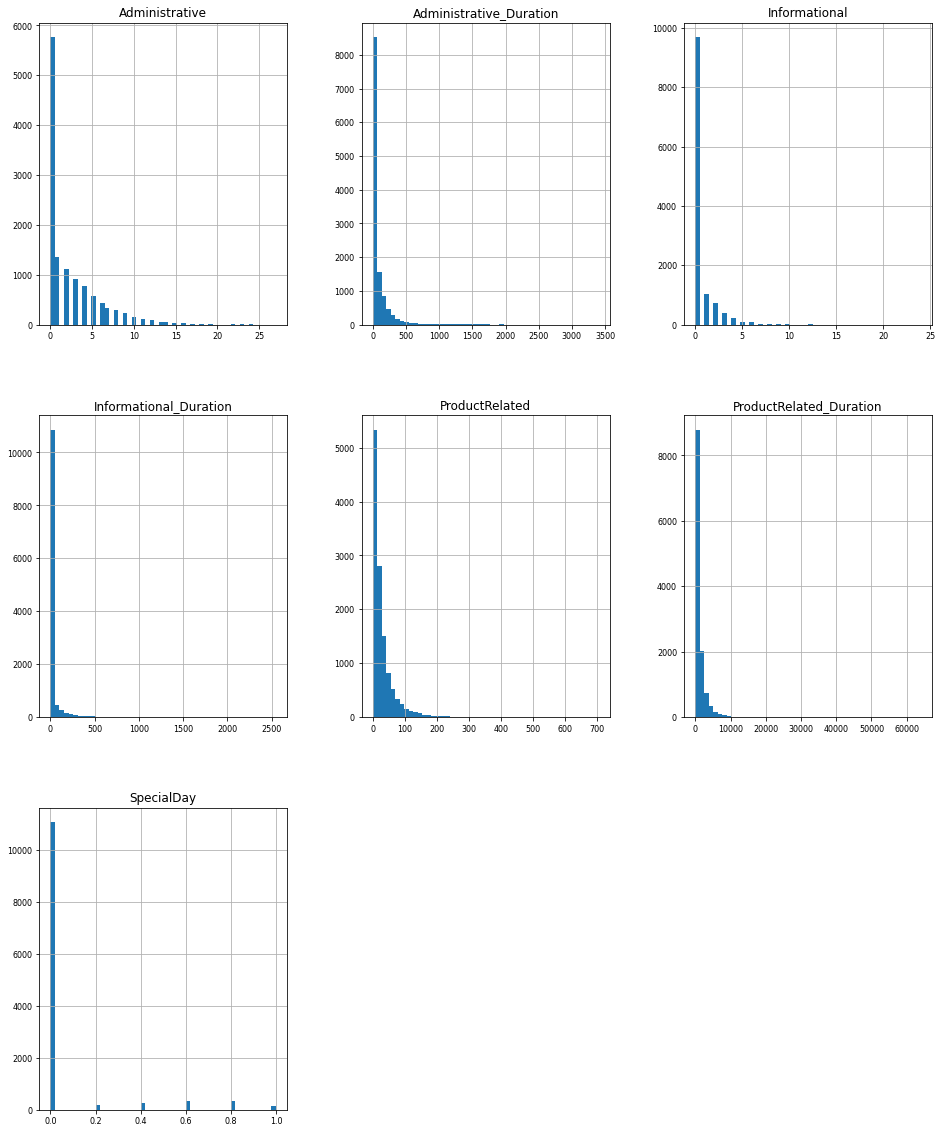

In [13]:
df1.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

> Como existem dados mistos. Não realizei ainda nenhuma padronização pois o algorítimo não iria conseguir ter saída. Portanto, seguirei assim até o momento em que tiver a oportunidade de padronizar

C:\Users\leand\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\leand\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\leand\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\leand\A

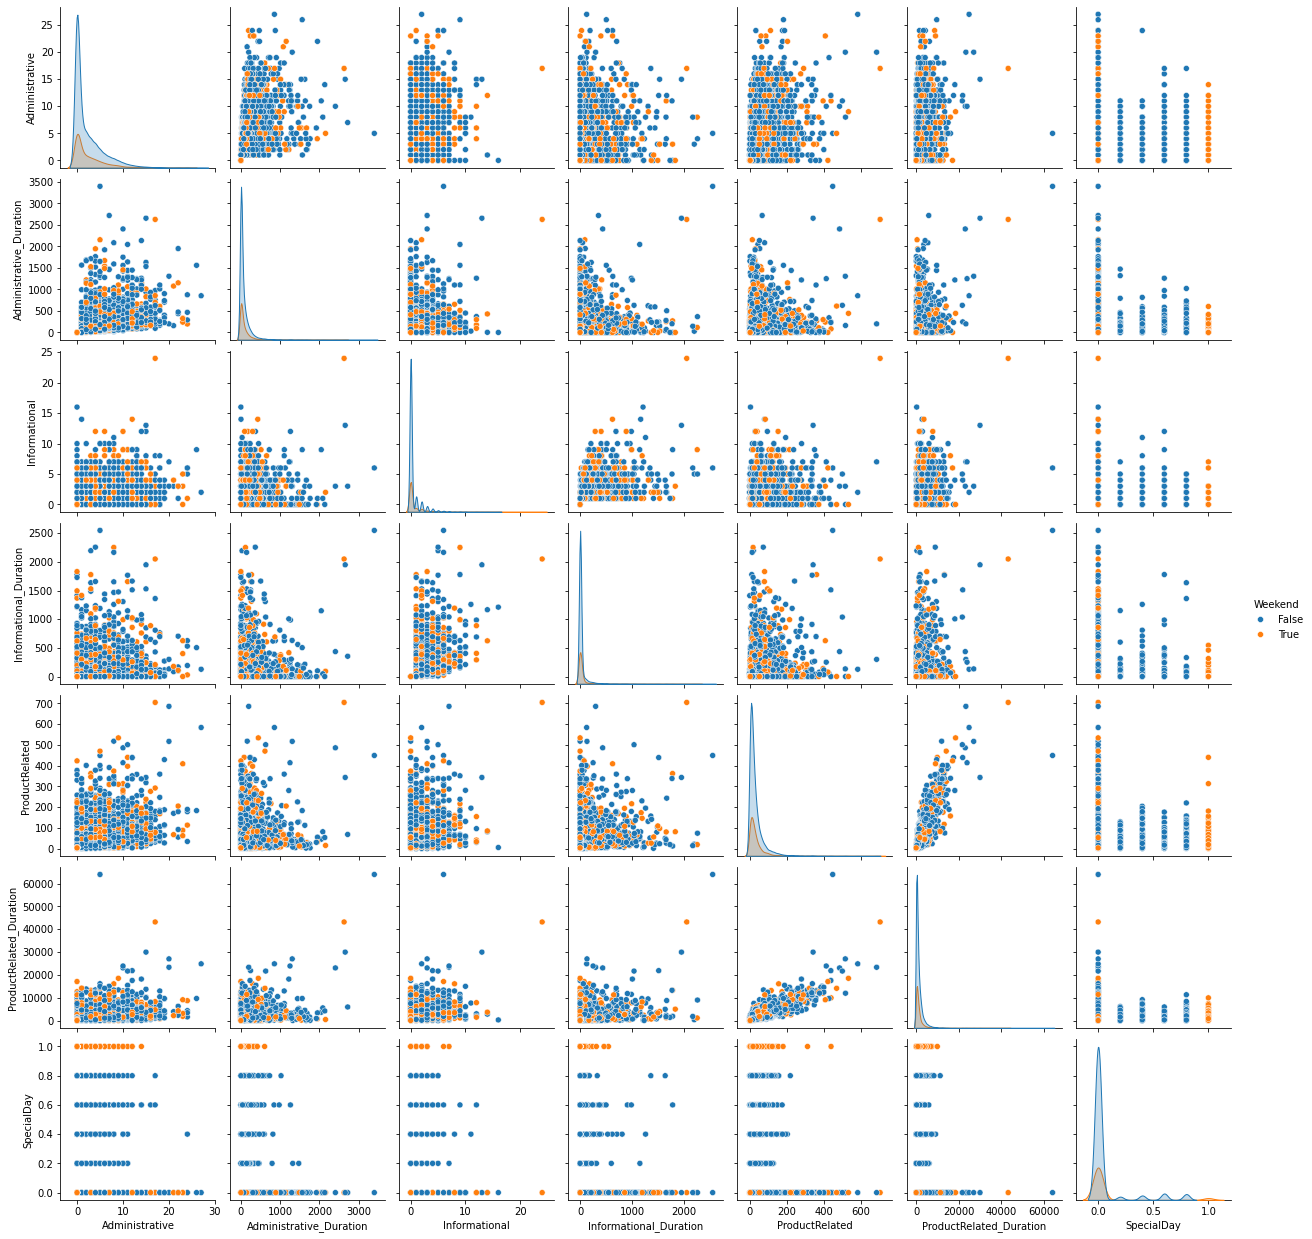

In [14]:
sns.pairplot(df1, hue='Weekend')

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [15]:
# criar uma df com as variáveis de interesse
df1 = df[['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']]
# eu não sabia ao certo se a var Revenue entraria nessa análise dessa vez
# selecionei inicialmente somentes as variaveis numéricas de interesse
#variáveis quantitativas
var_qtd = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']

**Variáveis que informam padrão de navegação:** 'Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration'
       
**Variáveis que apontam características de data:** 'SpecialDay', 'Weekend', 'Month'

>Honestamente, não consegui compreender como interpretar a var 'SpecialDay'. Como ela é float, não sei o que os números representam se 0.0 é o dia especial e não há distância, ou se 1.0 é o dia especial e por isso tem valor. Ou se 1.0 seria a maior distância possível e tudo acima disso seria trataddo com 1.0... Algo me diz que ela também é categórica, por causa do formato dos dados. Enfim, não entendi. 

In [16]:
# padronizando os dados
df_pad = pd.DataFrame(StandardScaler().fit_transform(df1), columns = df1.columns)
df_pad

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430
...,...,...,...,...,...,...
12325,0.206173,0.363075,-0.396478,-0.244931,0.478227,0.307822
12326,-0.696993,-0.457191,-0.396478,-0.244931,-0.601062,-0.380957
12327,-0.696993,-0.457191,-0.396478,-0.244931,-0.578577,-0.528063
12328,0.507228,-0.032916,-0.396478,-0.244931,-0.376210,-0.443536


In [57]:
#adicionando as colunas qualitativas categóricas de interesse
df_pad2 = pd.merge( df_pad.reset_index(), df[['SpecialDay', 'Weekend', 'Month']].reset_index(), how='left')
df_pad2.drop('index', axis = 1, inplace =True)
df_pad2

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay,Weekend,Month
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,0.0,False,Feb
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,0.0,False,Feb
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,0.0,False,Feb
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.0,False,Feb
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,0.0,True,Feb
...,...,...,...,...,...,...,...,...,...
12325,0.206173,0.363075,-0.396478,-0.244931,0.478227,0.307822,0.0,True,Dec
12326,-0.696993,-0.457191,-0.396478,-0.244931,-0.601062,-0.380957,0.0,True,Nov
12327,-0.696993,-0.457191,-0.396478,-0.244931,-0.578577,-0.528063,0.0,True,Nov
12328,0.507228,-0.032916,-0.396478,-0.244931,-0.376210,-0.443536,0.0,False,Nov


In [58]:
# na primeira vez que tentei resolver a atividade essa variável me trouxe muito prolema, então transformei-a em categórica de fato
SpecialDay = {0.0:"0", 0.2:"0.2", 0.4:"0.4",0.6:"0.6",0.8:'0.8',1.0:'1.0'}
df_pad2['SpecialDay'] = df_pad2['SpecialDay'].map(SpecialDay)
df_pad2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay,Weekend,Month
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,0,False,Feb
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,0,False,Feb
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,0,False,Feb
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0,False,Feb
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,0,True,Feb


**ESTOU ASSUMINDO QUE A VAR ```SpecialDay``` TEM O SEGUINTE COMPORTAMENTO PARA OS VALORES:**
- ```1.0```: É O DIA DA DATA ESPECIAL
- ```0.0```: É O DIA MAIS DISTANTE POSSÍVEL DA DATA ESPECIAL

In [71]:
variaveis = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'Weekend', 'SpecialDay_0', 'SpecialDay_0.2', 'SpecialDay_0.4',
       'SpecialDay_0.6', 'SpecialDay_0.8', 'SpecialDay_1.0', 'Month_Aug',
       'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep']

In [59]:
#tratando dados qualitativos
df_pad2 = pd.get_dummies(df_pad2.dropna())
df_pad2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Weekend,SpecialDay_0,SpecialDay_0.2,SpecialDay_0.4,...,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,True,True,False,False,...,False,False,True,False,False,False,False,False,False,False


In [60]:
df_pad2.isnull().sum()
#Não há missings

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
Weekend                    0
SpecialDay_0               0
SpecialDay_0.2             0
SpecialDay_0.4             0
SpecialDay_0.6             0
SpecialDay_0.8             0
SpecialDay_1.0             0
Month_Aug                  0
Month_Dec                  0
Month_Feb                  0
Month_Jul                  0
Month_June                 0
Month_Mar                  0
Month_May                  0
Month_Nov                  0
Month_Oct                  0
Month_Sep                  0
dtype: int64

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [61]:
df_pad2.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'Weekend', 'SpecialDay_0', 'SpecialDay_0.2', 'SpecialDay_0.4',
       'SpecialDay_0.6', 'SpecialDay_0.8', 'SpecialDay_1.0', 'Month_Aug',
       'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep'],
      dtype='object')

In [23]:
df.Month.nunique()
# achei estranho termos somente 10 meses. Mas aparentemente a base original também é assim

10

In [62]:
vars_cat = [True if x in {'SpecialDay_0', 'SpecialDay_0.2', 'SpecialDay_0.4',
       'SpecialDay_0.6', 'SpecialDay_0.8', 'SpecialDay_1.0','Month_Aug', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep'} else False for x in df_pad2.columns]
vars_cat

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [63]:
len(vars_cat)

23

In [64]:
df_pad2.shape
# parece que está tudo certo e a função categorizou todas as vars

(12330, 23)

> Criando os agrupamentos

In [65]:
distancia_gower = gower_matrix(df_pad2, cat_features=vars_cat) # criando objeto com a distancia gower
gdv = squareform(distancia_gower,force='tovector') # criando uma matriz para alimentar o algorítimo de agrupamento
Z = linkage(gdv, method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df 
# só pra visualizar a saída num formato mais conveniente

,id1,id2,dist,n
0,0.0,2.0,0.000000,2.0
1,16.0,12330.0,0.000000,3.0
2,6.0,79.0,0.000000,2.0
3,24.0,50.0,0.000000,2.0
4,91.0,12333.0,0.000000,3.0
...,...,...,...,...
12324,24652.0,24653.0,0.270344,10971.0
12325,24635.0,24641.0,0.273794,333.0
12326,24645.0,24655.0,0.297741,1356.0
12327,24654.0,24656.0,0.330411,12327.0


In [66]:
# criando 3 grupos
df_pad2['grupo_3'] = fcluster(Z, 3, criterion='maxclust')
df_pad2.grupo_3.value_counts()

grupo_3
2    10971
3     1356
1        3
Name: count, dtype: int64

In [67]:
# criando 4 grupos
df_pad2['grupo_4'] = fcluster(Z, 4, criterion='maxclust')
df_pad2.grupo_4.value_counts()

grupo_4
2    10971
3     1023
4      333
1        3
Name: count, dtype: int64

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

**Pergunta inicial:** "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?"

In [68]:
df_pad2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Weekend,SpecialDay_0,SpecialDay_0.2,SpecialDay_0.4,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,grupo_3,grupo_4
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,False,True,False,False,...,True,False,False,False,False,False,False,False,3,4
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,False,True,False,False,...,True,False,False,False,False,False,False,False,3,4
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,False,True,False,False,...,True,False,False,False,False,False,False,False,3,4
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,False,True,False,False,...,True,False,False,False,False,False,False,False,3,4
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,True,True,False,False,...,True,False,False,False,False,False,False,False,3,4


### 3 Variáveis

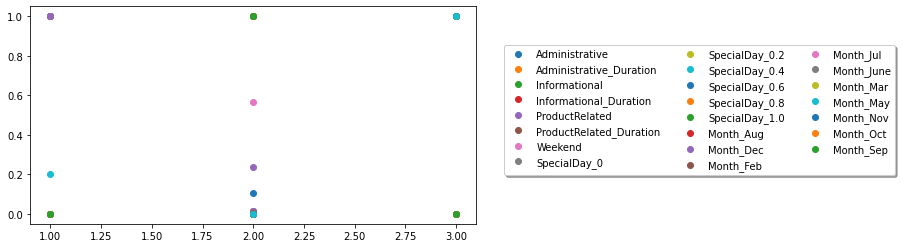

In [82]:
# para 3 variáveis
padroniza = lambda x: (x - x.min())/(x.max() - x.min())

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_pad2.groupby(['grupo_3'])[variaveis].mean().apply(padroniza), 'o ')
ax.legend(variaveis, loc='lower center', bbox_to_anchor=(1.5, 0.2),
          ncol=3, fancybox=True, shadow=True)

In [83]:
df_pad2.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'Weekend', 'SpecialDay_0', 'SpecialDay_0.2', 'SpecialDay_0.4',
       'SpecialDay_0.6', 'SpecialDay_0.8', 'SpecialDay_1.0', 'Month_Aug',
       'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'grupo_3',
       'grupo_4'],
      dtype='object')

In [128]:
#criando um data frame para cada contagem de vezes que uma variável aparece para um grupo 3

ad = df_pad2.groupby(['Administrative', 'grupo_3'])['grupo_3'].count().unstack().count()
adD = df_pad2.groupby(['Administrative_Duration', 'grupo_3'])['grupo_3'].count().unstack().count()
inf = df_pad2.groupby(['Informational', 'grupo_3'])['grupo_3'].count().unstack().count()
infD = df_pad2.groupby(['Informational_Duration', 'grupo_3'])['grupo_3'].count().unstack().count()
pr = df_pad2.groupby(['ProductRelated', 'grupo_3'])['grupo_3'].count().unstack().count()
prD = df_pad2.groupby(['ProductRelated_Duration', 'grupo_3'])['grupo_3'].count().unstack().count()
sp_0 = df_pad2.groupby(['SpecialDay_0', 'grupo_3'])['grupo_3'].count().unstack().count()
sp_2 = df_pad2.groupby(['SpecialDay_0.2', 'grupo_3'])['grupo_3'].count().unstack().count()
sp_4 = df_pad2.groupby(['SpecialDay_0.4', 'grupo_3'])['grupo_3'].count().unstack().count()
sp_6 = df_pad2.groupby(['SpecialDay_0.6', 'grupo_3'])['grupo_3'].count().unstack().count()
sp_8 = df_pad2.groupby(['SpecialDay_0.8', 'grupo_3'])['grupo_3'].count().unstack().count()
sp_10 = df_pad2.groupby(['SpecialDay_1.0', 'grupo_3'])['grupo_3'].count().unstack().count()
wnd = df_pad2.groupby(['Weekend', 'grupo_3'])['grupo_3'].sum().unstack().sum() # variável booleana o sum() capta melhor a info
m_aug = df_pad2.groupby(['Month_Aug', 'grupo_3'])['grupo_3'].count().unstack().count()
m_dec = df_pad2.groupby(['Month_Dec', 'grupo_3'])['grupo_3'].count().unstack().count()
m_feb = df_pad2.groupby(['Month_Feb', 'grupo_3'])['grupo_3'].count().unstack().count()
m_jul = df_pad2.groupby(['Month_Jul', 'grupo_3'])['grupo_3'].count().unstack().count()
m_jun = df_pad2.groupby(['Month_June', 'grupo_3'])['grupo_3'].count().unstack().count()
m_mar = df_pad2.groupby(['Month_Mar', 'grupo_3'])['grupo_3'].count().unstack().count()
m_may = df_pad2.groupby(['Month_May', 'grupo_3'])['grupo_3'].count().unstack().count()
m_nov = df_pad2.groupby(['Month_Nov', 'grupo_3'])['grupo_3'].count().unstack().count()
m_oct = df_pad2.groupby(['Month_Oct', 'grupo_3'])['grupo_3'].count().unstack().count()
m_sep = df_pad2.groupby(['Month_Sep', 'grupo_3'])['grupo_3'].count().unstack().count()


In [129]:
#juntando todos os df em um só df
freq_var = pd.concat([ad,adD,inf,infD,pr,prD,sp_0,sp_2,sp_4,sp_6,sp_8,sp_10,wnd, m_aug,m_dec,m_feb,m_jul,m_jun,m_mar,m_may,m_nov,m_oct,m_sep], 
                     axis=  1, names = [ad,adD,inf,infD,pr,prD,sp_0,sp_2,sp_4,sp_6,sp_8,sp_10,wnd, m_aug,m_dec,m_feb,m_jul,m_jun,m_mar,m_may,m_nov,m_oct,m_sep], 
                     join = 'outer',)
freq_var.columns = ['ad','adD','inf','infD','pr','prD','sp_0','sp_2','sp_4','sp_6','sp_8','sp_10','wnd', 'm_aug','m_dec','m_feb','m_jul','m_jun','m_mar','m_may','m_nov','m_oct','m_sep']
freq_var
# a tabela abaixo contem a quantidade de cada presença de variável por grupo

,ad,adD,inf,infD,pr,prD,sp_0,sp_2,sp_4,sp_6,...,m_aug,m_dec,m_feb,m_jul,m_jun,m_mar,m_may,m_nov,m_oct,m_sep
grupo_3,,,,,,,,,,,,,,,,,,,,,
1,3,3,3,3,3,3,1,1,1,1,...,1,2,1,1,1,1,2,1,1,1
2,27,3205,14,1208,306,8759,1,1,1,1,...,2,2,1,2,2,2,2,2,2,2
3,17,319,12,134,136,1108,2,2,2,2,...,1,1,2,1,1,1,2,1,1,1


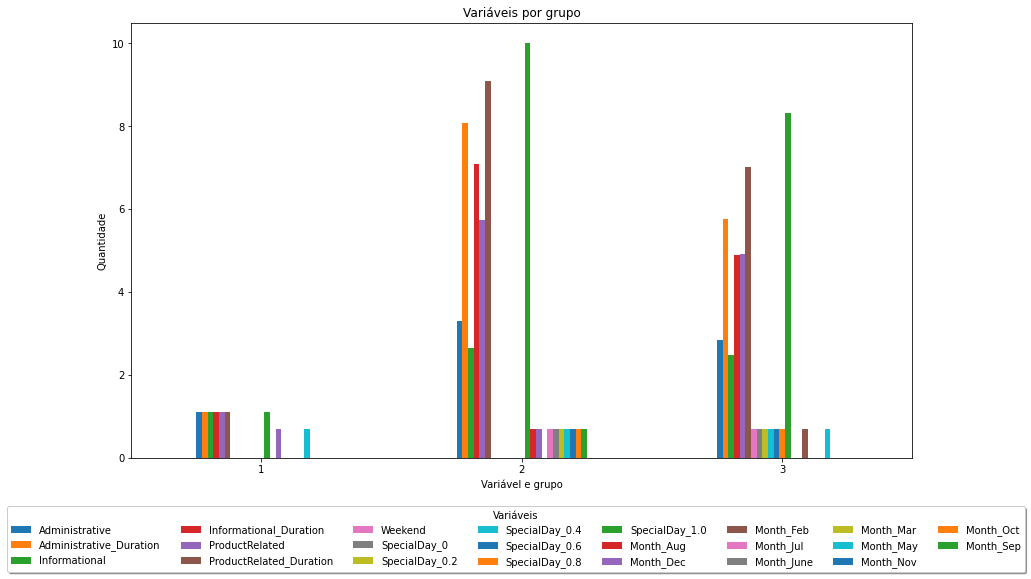

In [130]:
np.log(freq_var).plot.bar(figsize=(14, 8))
#np.log(freq_var[['ad', 'adD', 'inf', 'infD', 'pr', 'prD']]).plot.bar(figsize=(10, 5)) # apliquei log para uma melhor visualização
#freq_var[['sp_0','sp_2','sp_4','sp_6','sp_8','sp_10', 'wnd', 'm_aug', 'm_dec','m_feb', 'm_jul', 'm_jun', 'm_mar', 'm_may', 'm_nov', 'm_oct', 'm_sep']].plot.bar(figsize=(10, 5)) # apliquei log para uma melhor visualização


plt.tick_params(axis='x', labelrotation=0)
plt.title('Variáveis por grupo')
plt.xlabel('Variável e grupo')
plt.ylabel('Quantidade')
#plt.ylabel('Quantidade em log')

plt.legend(title= 'Variáveis', loc = 'best', bbox_to_anchor = (1.15, -.1),
         ncol=8, fancybox=True, shadow=True,
          labels = df_pad2.columns # a depender de quais variáveis se deseja observar, essa linha participa ou não
          );

**Proposição de nomes de grupos**

| GRUPO | NOME | DESCRIÇÃO BÁSICA |
|-  |-  |-  |
|```1``` | "Desanimados"        | Acessos desinteressados e sem muita pretensão. |
|```2``` | "Atraso comemorativo"| Acessos durante uma data comemorativa ao longo do ano. |
|```3``` | "Me preparo"         | Acessos recorrentes ao longo dos meses e que não fazem diferença se está próximo de uma data comemorativa. |

In [106]:
grupos = {1:"Desanimados", 2:"Atraso comemorativo", 3:"Me preparo",}
df_pad2['g3_nomes'] = df_pad2['grupo_3'].map(grupos)
df_pad2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Weekend,SpecialDay_0,SpecialDay_0.2,SpecialDay_0.4,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,grupo_3,grupo_4,g3_nomes
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,False,True,False,False,...,False,False,False,False,False,False,False,3,4,Me preparo
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,False,True,False,False,...,False,False,False,False,False,False,False,3,4,Me preparo
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,False,True,False,False,...,False,False,False,False,False,False,False,3,4,Me preparo
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,False,True,False,False,...,False,False,False,False,False,False,False,3,4,Me preparo
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,True,True,False,False,...,False,False,False,False,False,False,False,3,4,Me preparo


In [114]:
freq_var.index = 'Desanimados','Atraso comemorativo','Me preparo'
freq_var

,ad,adD,inf,infD,pr,prD,sp_0,sp_2,sp_4,sp_6,...,m_aug,m_dec,m_feb,m_jul,m_jun,m_mar,m_may,m_nov,m_oct,m_sep
Desanimados,3,3,3,3,3,3,1,1,1,1,...,1,2,1,1,1,1,2,1,1,1
Atraso comemorativo,27,3205,14,1208,306,8759,1,1,1,1,...,2,2,1,2,2,2,2,2,2,2
Me preparo,17,319,12,134,136,1108,2,2,2,2,...,1,1,2,1,1,1,2,1,1,1


### 4 Variáveis

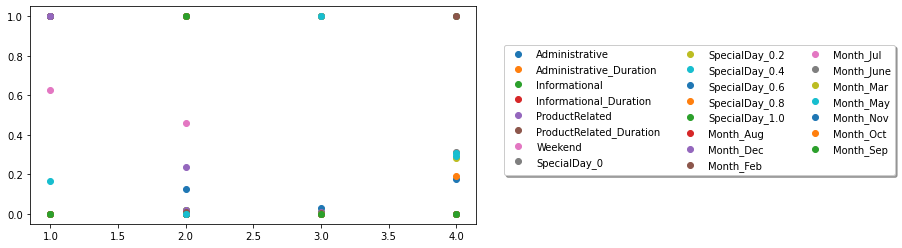

In [116]:
# para 4 variáveis
padroniza = lambda x: (x - x.min())/(x.max() - x.min())

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_pad2.groupby(['grupo_4'])[variaveis].mean().apply(padroniza), 'o ')
ax.legend(variaveis, loc='lower center', bbox_to_anchor=(1.5, 0.2),
          ncol=3, fancybox=True, shadow=True)

In [119]:
#criando um data frame para cada contagem de vezes que uma variável aparece para um grupo 4

ad = df_pad2.groupby(['Administrative', 'grupo_4'])['grupo_4'].count().unstack().count()
adD = df_pad2.groupby(['Administrative_Duration', 'grupo_4'])['grupo_4'].count().unstack().count()
inf = df_pad2.groupby(['Informational', 'grupo_4'])['grupo_4'].count().unstack().count()
infD = df_pad2.groupby(['Informational_Duration', 'grupo_4'])['grupo_4'].count().unstack().count()
pr = df_pad2.groupby(['ProductRelated', 'grupo_4'])['grupo_4'].count().unstack().count()
prD = df_pad2.groupby(['ProductRelated_Duration', 'grupo_4'])['grupo_4'].count().unstack().count()
sp_0 = df_pad2.groupby(['SpecialDay_0', 'grupo_3'])['grupo_3'].count().unstack().count()
sp_2 = df_pad2.groupby(['SpecialDay_0.2', 'grupo_3'])['grupo_3'].count().unstack().count()
sp_4 = df_pad2.groupby(['SpecialDay_0.4', 'grupo_3'])['grupo_3'].count().unstack().count()
sp_6 = df_pad2.groupby(['SpecialDay_0.6', 'grupo_3'])['grupo_3'].count().unstack().count()
sp_8 = df_pad2.groupby(['SpecialDay_0.8', 'grupo_3'])['grupo_3'].count().unstack().count()
sp_10 = df_pad2.groupby(['SpecialDay_1.0', 'grupo_3'])['grupo_3'].count().unstack().count()
wnd = df_pad2.groupby(['Weekend', 'grupo_4'])['grupo_4'].sum().unstack().sum() # variável booleana o sum() capta melhor a info
m_aug = df_pad2.groupby(['Month_Aug', 'grupo_4'])['grupo_4'].count().unstack().count()
m_dec = df_pad2.groupby(['Month_Dec', 'grupo_4'])['grupo_4'].count().unstack().count()
m_feb = df_pad2.groupby(['Month_Feb', 'grupo_4'])['grupo_4'].count().unstack().count()
m_jul = df_pad2.groupby(['Month_Jul', 'grupo_4'])['grupo_4'].count().unstack().count()
m_jun = df_pad2.groupby(['Month_June','grupo_4'])['grupo_4'].count().unstack().count()
m_mar = df_pad2.groupby(['Month_Mar', 'grupo_4'])['grupo_4'].count().unstack().count()
m_may = df_pad2.groupby(['Month_May', 'grupo_4'])['grupo_4'].count().unstack().count()
m_nov = df_pad2.groupby(['Month_Nov', 'grupo_4'])['grupo_4'].count().unstack().count()
m_oct = df_pad2.groupby(['Month_Oct', 'grupo_4'])['grupo_4'].count().unstack().count()
m_sep = df_pad2.groupby(['Month_Sep', 'grupo_4'])['grupo_4'].count().unstack().count()

#juntando todos os df em um só df
freq_var1 = pd.concat([ad,adD,inf,infD,pr,prD,sp_0,sp_2,sp_4,sp_6,sp_8,sp_10,wnd, m_aug,m_dec,m_feb,m_jul,m_jun,m_mar,m_may,m_nov,m_oct,m_sep], 
                     axis=  1, names = [ad,adD,inf,infD,pr,prD,sp_0,sp_2,sp_4,sp_6,sp_8,sp_10,wnd, m_aug,m_dec,m_feb,m_jul,m_jun,m_mar,m_may,m_nov,m_oct,m_sep], 
                     join = 'outer',)
freq_var1.columns = ['ad','adD','inf','infD','pr','prD','sp_0','sp_2','sp_4','sp_6','sp_8','sp_10','wnd', 'm_aug','m_dec','m_feb','m_jul','m_jun','m_mar','m_may','m_nov','m_oct','m_sep']
freq_var1
# a tabela abaixo contem a quantidade de cada presença de variável por grupo

,ad,adD,inf,infD,pr,prD,sp_0,sp_2,sp_4,sp_6,...,m_aug,m_dec,m_feb,m_jul,m_jun,m_mar,m_may,m_nov,m_oct,m_sep
1,3,3,3,3,3,3,1.0,1.0,1.0,1.0,...,1,2,1,1,1,1,2,1,1,1
2,27,3205,14,1208,306,8759,1.0,1.0,1.0,1.0,...,2,2,1,2,2,2,2,2,2,2
3,17,268,12,114,127,874,2.0,2.0,2.0,2.0,...,1,1,1,1,1,1,1,1,1,1
4,14,79,7,33,70,283,NaN,NaN,NaN,NaN,...,1,1,2,1,1,1,2,1,1,1


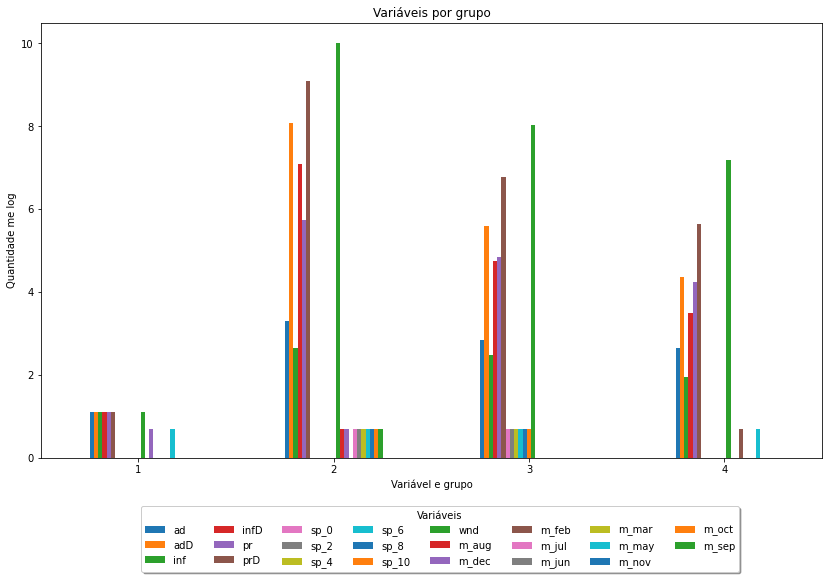

In [127]:
np.log(freq_var1).plot.bar(figsize=(14, 8)) # apliquei log para uma melhor visualização
#np.log(freq_var1[['ad', 'adD', 'inf', 'infD', 'pr', 'prD']]).plot.bar(figsize=(10, 5)) # apliquei log para uma melhor visualização
#freq_var1[['sp_0','sp_2','sp_4','sp_6','sp_8','sp_10', 'wnd', 'm_aug', 'm_dec','m_feb', 'm_jul', 'm_jun', 'm_mar', 'm_may', 'm_nov', 'm_oct', 'm_sep']].plot.bar(figsize=(10, 5)) # apliquei log para uma melhor visualização

plt.tick_params(axis='x', labelrotation=0)
plt.title('Variáveis por grupo')
plt.xlabel('Variável e grupo')
plt.ylabel('Quantidade me log')
#plt.ylabel('Quantidade')

plt.legend(title= 'Variáveis', loc = 'best', bbox_to_anchor = (.9, -.1),
         ncol=8, fancybox=True, shadow=True
          #labels = df_pad2.columns # a depender de quais variáveis se deseja observar, essa linha participa ou não
          );

**Proposição de nomes de grupos**

| GRUPO | NOME | DESCRIÇÃO BÁSICA |
|-  |-  |-  |
|```1``` | "Desanimados"           | Acessos desinteressados e sem muita pretensão. |
|```2``` | "Acesso no fds"         | Acessos mais frequentes nos finais de semana durante todos os meses observados.|
|```3``` | "Me preparo"            | Acessos que não fazem diferença se próximo a uma data comemorativa. |
|```4``` | "Acesso sem compromisso"| Não há evidência de acessos para datas comemorativas.|

In [131]:
grupos1 = {1:"Desanimados", 2:"Acesso no fds", 3:"Me preparo",4:"Acesso sem compromisso"}
df_pad2['g4_nomes'] = df_pad2['grupo_4'].map(grupos1)
df_pad2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Weekend,SpecialDay_0,SpecialDay_0.2,SpecialDay_0.4,...,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,grupo_3,grupo_4,g3_nomes,g4_nomes
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,False,True,False,False,...,False,False,False,False,False,False,3,4,Me preparo,Acesso sem compromisso
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,False,True,False,False,...,False,False,False,False,False,False,3,4,Me preparo,Acesso sem compromisso
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,False,True,False,False,...,False,False,False,False,False,False,3,4,Me preparo,Acesso sem compromisso
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,False,True,False,False,...,False,False,False,False,False,False,3,4,Me preparo,Acesso sem compromisso
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,True,True,False,False,...,False,False,False,False,False,False,3,4,Me preparo,Acesso sem compromisso


In [132]:
freq_var1.index = 'Desanimados',"Acesso no fds",'Me preparo',"Acesso sem compromisso"
freq_var1

,ad,adD,inf,infD,pr,prD,sp_0,sp_2,sp_4,sp_6,...,m_aug,m_dec,m_feb,m_jul,m_jun,m_mar,m_may,m_nov,m_oct,m_sep
Desanimados,3,3,3,3,3,3,1.0,1.0,1.0,1.0,...,1,2,1,1,1,1,2,1,1,1
Acesso no fds,27,3205,14,1208,306,8759,1.0,1.0,1.0,1.0,...,2,2,1,2,2,2,2,2,2,2
Me preparo,17,268,12,114,127,874,2.0,2.0,2.0,2.0,...,1,1,1,1,1,1,1,1,1,1
Acesso sem compromisso,14,79,7,33,70,283,NaN,NaN,NaN,NaN,...,1,1,2,1,1,1,2,1,1,1


## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [137]:
df_pad2.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'Weekend', 'SpecialDay_0', 'SpecialDay_0.2', 'SpecialDay_0.4',
       'SpecialDay_0.6', 'SpecialDay_0.8', 'SpecialDay_1.0', 'Month_Aug',
       'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'grupo_3',
       'grupo_4', 'g3_nomes', 'g4_nomes'],
      dtype='object')

In [133]:
df_pad3 = pd.merge( df_pad2.reset_index(), df[['Revenue', 'BounceRates']].reset_index(), how='left')
df_pad3.drop('index', axis = 1, inplace =True)
df_pad3.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Weekend,SpecialDay_0,SpecialDay_0.2,SpecialDay_0.4,...,Month_May,Month_Nov,Month_Oct,Month_Sep,grupo_3,grupo_4,g3_nomes,g4_nomes,Revenue,BounceRates
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,False,True,False,False,...,False,False,False,False,3,4,Me preparo,Acesso sem compromisso,False,0.20
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,False,True,False,False,...,False,False,False,False,3,4,Me preparo,Acesso sem compromisso,False,0.00
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,False,True,False,False,...,False,False,False,False,3,4,Me preparo,Acesso sem compromisso,False,0.20
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,False,True,False,False,...,False,False,False,False,3,4,Me preparo,Acesso sem compromisso,False,0.05
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,True,True,False,False,...,False,False,False,False,3,4,Me preparo,Acesso sem compromisso,False,0.02


In [135]:
# criei as categorias para o bounce rates para facilitar os agrupamentos
df_pad3['br_class'] = pd.qcut(df_pad3.BounceRates, q=4,
                       labels = [
                                 'small rate',
                                 'medium rate',
                                 'large rate',
                                 ],
                       duplicates = 'drop') # usei esta linha pra ignorar as duplicatas
df_pad3.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Weekend,SpecialDay_0,SpecialDay_0.2,SpecialDay_0.4,...,Month_Nov,Month_Oct,Month_Sep,grupo_3,grupo_4,g3_nomes,g4_nomes,Revenue,BounceRates,br_class
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,False,True,False,False,...,False,False,False,3,4,Me preparo,Acesso sem compromisso,False,0.20,large rate
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,False,True,False,False,...,False,False,False,3,4,Me preparo,Acesso sem compromisso,False,0.00,small rate
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,False,True,False,False,...,False,False,False,3,4,Me preparo,Acesso sem compromisso,False,0.20,large rate
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,False,True,False,False,...,False,False,False,3,4,Me preparo,Acesso sem compromisso,False,0.05,large rate
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,True,True,False,False,...,False,False,False,3,4,Me preparo,Acesso sem compromisso,False,0.02,large rate


In [136]:
df_pad3.br_class.value_counts()

br_class
small rate     6165
large rate     3083
medium rate    3082
Name: count, dtype: int64

In [138]:
df_pad3.groupby(['g3_nomes', 'br_class','Revenue'])['Revenue'].count().unstack().fillna(0).style.format(precision=0)

<ipython-input-138-f1c973dbe03b>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pad3.groupby(['g3_nomes', 'br_class','Revenue'])['Revenue'].count().unstack().fillna(0).style.format(precision=0)


In [139]:
df_pad3.groupby(['g4_nomes', 'br_class','Revenue'])['Revenue'].count().unstack().fillna(0).style.format(precision=0)

<ipython-input-139-334387357e4c>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pad3.groupby(['g4_nomes', 'br_class','Revenue'])['Revenue'].count().unstack().fillna(0).style.format(precision=0)


## Conclusões
Após analizar ambos agrupamentos com 3 e 4 grupos distintos, o grupo que possui clientes mais propensos à compra, foram:

> Para 3 grupos os acessos nomeados com ```Atraso comemorativo``` tem a maior quantidade de compras efetivadas e o maior fluxo de entradas na página.

> Para 4 grupos, os acessos nomeados com ```Acesso no fds``` tem a maior quantidade de compras efetivadas e o maior fluxo de entradas na página.


> Além disso, os números de ambos os grupos com acessos mais propensos a finalizar comprar são idênticos. restaria outras análises para melhor compreensão desse fenômno